# Conditional Generative Advesarial Networks - Fashion MNIST

*   Name: Tarun Kumar Reddy
*   School: Computing and Data Science
*   Computer Vision Assignment-1



Importing the necessary libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [39]:
# Setting the seeds for both numpy and tensorflow for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Declaring the variables and hyperparameters

In [40]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 100

Loading and processing the data

In [41]:
# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
all_fashions = np.concatenate([X_train, X_test]) # Concatenate all images
all_labels = np.concatenate([y_train, y_test]) # Concatenate all labels

# Scale the pixel values to [0, 1] range, add a channel dimension to the images
all_fashions = all_fashions.astype(np.float32) / 255
all_fashions = np.reshape(all_fashions, (-1, image_size, image_size, num_channels))

#Encode the labels using One-Hot Encoding
all_labels = keras.utils.to_categorical(all_labels, num_classes)

print(f"Shape of all images: {all_fashions.shape}")
print(f"Shape of all labels: {all_labels.shape}")

Shape of all images: (70000, 28, 28, 1)
Shape of all labels: (70000, 10)


In [42]:
print("First 5 one-hot encoded labels:")
print(all_labels[:5])

First 5 one-hot encoded labels:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Declaring the input shapes

In [43]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

print(generator_in_channels, discriminator_in_channels)

110 11


Building the generator and discriminator

In [44]:
# Reverse Convolutions for Generator (Constructor method)
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[generator_in_channels]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

# CNN for Discriminator (Constructor method)
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=tf.keras.layers.LeakyReLU(0.2),
                        input_shape=[image_size, image_size, discriminator_in_channels]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

Compile the Discriminator CNN model

In [45]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="binary_crossentropy")

# Freeze the Discriminator CNN model
discriminator.trainable = False

Combine generator and discriminator along with class labels to obtain CGAN

In [46]:
gan_input = keras.layers.Input(shape=[generator_in_channels, ])
generated_image = generator(gan_input)

labels = gan_input[:, -num_classes:]
image_one_hot_labels = keras.layers.Reshape((1,1, num_classes))(labels)
image_one_hot_labels = keras.layers.Lambda(lambda x: tf.tile(x, (1, image_size, image_size, 1)))(image_one_hot_labels)
generated_image_with_labels = keras.layers.concatenate([generated_image, image_one_hot_labels], axis=-1)

gan_output = discriminator(generated_image_with_labels)
cgan = keras.models.Model(gan_input, gan_output)

# Compile the GAN
cgan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="binary_crossentropy")

Declare a function that uses generator and produce images of all classes

In [47]:
def generate_and_plot_fashion_mnist(generator, n_images=32, n_classes=10):
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    fig, axes = plt.subplots(n_classes, n_images, figsize=(n_images*1.5, n_classes*1.5))
    fig.suptitle("Generated Fashion MNIST Images for Each Class", fontsize=20)

    for class_idx in range(n_classes):
        # Generate noise
        noise = tf.random.normal(shape=[n_images, latent_dim])

        # Create one-hot encoded labels for the class
        labels = np.zeros((n_images, 10))
        labels[:, class_idx] = 1

        # Concatenate noise and labels
        generator_input = tf.concat([noise, labels], axis=1)

        # Generate images
        generated_images = generator(generator_input, training=False)

        # Plot images
        for img_idx in range(n_images):
            ax = axes[class_idx, img_idx]
            ax.imshow(generated_images[img_idx, :, :, 0], cmap='gray')
            ax.axis('off')
            if img_idx == 0:
                ax.set_title(class_names[class_idx], rotation=90, fontsize=8, va='center')

    plt.tight_layout()
    plt.show()

Declare a function to generate images for the given class

In [48]:
def generate_plot_class(generator,n_images=32, class_label=0):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Generate noise
    noise = tf.random.normal(shape=[n_images, latent_dim])

    # Create one-hot encoded labels for the class
    labels = np.zeros((n_images, 10))
    labels = np.array([[1 if i == class_label else 0 for i in range(num_classes)] for _ in range(n_images)])

    # Concatenate noise and labels
    generator_input = tf.concat([noise, labels], axis=1)

    # Generating images
    generated_images = generator(generator_input, training=False)

    plt.figure(figsize=(n_images*1.5, 10))

    # Plotting generated images with title
    for i in range(n_images):
        plt.subplot(class_label, n_images, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[class_label], fontsize=40)

    # Adjusting spacing between subplots
    plt.tight_layout()
    plt.show()

Declare a function for training the CGAN

In [49]:
def train_cgan(batch_size, epochs=5):

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        for i in range(len(all_fashions) // batch_size):
            # Get the real images and labels
            real_images = all_fashions[i * batch_size:(i + 1) * batch_size]
            real_labels = all_labels[i * batch_size:(i + 1) * batch_size]

            # Phase 1: Train the Discriminator
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            noise_with_labels = np.concatenate((noise, real_labels), axis=1)

            generated_images = generator(noise_with_labels, training=False)

            # Create one-hot labels for the generated images
            image_one_hot_labels = np.reshape(real_labels, (-1, 1, 1, num_classes))
            image_one_hot_labels = np.tile(image_one_hot_labels, (1, image_size, image_size, 1))

            # Concatenate generated images and their one-hot labels
            generated_images_with_labels = np.concatenate((generated_images, image_one_hot_labels), axis=-1)

            # Concatenate real images and labels
            real_images_with_labels = np.concatenate((real_images, image_one_hot_labels), axis=-1)

            # Prepare the combined dataset for the discriminator
            X_fake_and_real = np.concatenate((generated_images_with_labels, real_images_with_labels), axis=0)
            y_fake_and_real = np.array([[0.]] * batch_size + [[1.]] * batch_size)

            # Train the Discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_fake_and_real, y_fake_and_real)

            # Phase 2: Train the Generator
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            noise_with_labels = np.concatenate((noise, real_labels), axis=1)

            y_gen = np.array([[1.]] * batch_size)
            discriminator.trainable = False
            g_loss = cgan.train_on_batch(noise_with_labels, y_gen)

        print(f"D Loss: {d_loss}, G Loss: {g_loss}")

Train the CAGN for 10 epochs

In [50]:
train_cgan(epochs=10, batch_size=batch_size)

Epoch 1/10
D Loss: 0.44443559646606445, G Loss: 1.1991162300109863
Epoch 2/10
D Loss: 0.4937587380409241, G Loss: 1.8254495859146118
Epoch 3/10
D Loss: 0.46167898178100586, G Loss: 1.7863895893096924
Epoch 4/10
D Loss: 0.40088704228401184, G Loss: 1.998464584350586
Epoch 5/10
D Loss: 0.45990806818008423, G Loss: 2.167250156402588
Epoch 6/10
D Loss: 0.40690845251083374, G Loss: 1.6779038906097412
Epoch 7/10
D Loss: 0.39026427268981934, G Loss: 1.3798714876174927
Epoch 8/10
D Loss: 0.41625040769577026, G Loss: 1.9683369398117065
Epoch 9/10
D Loss: 0.45043468475341797, G Loss: 1.4733612537384033
Epoch 10/10
D Loss: 0.4846753478050232, G Loss: 1.6148008108139038


Plot images for all the classes

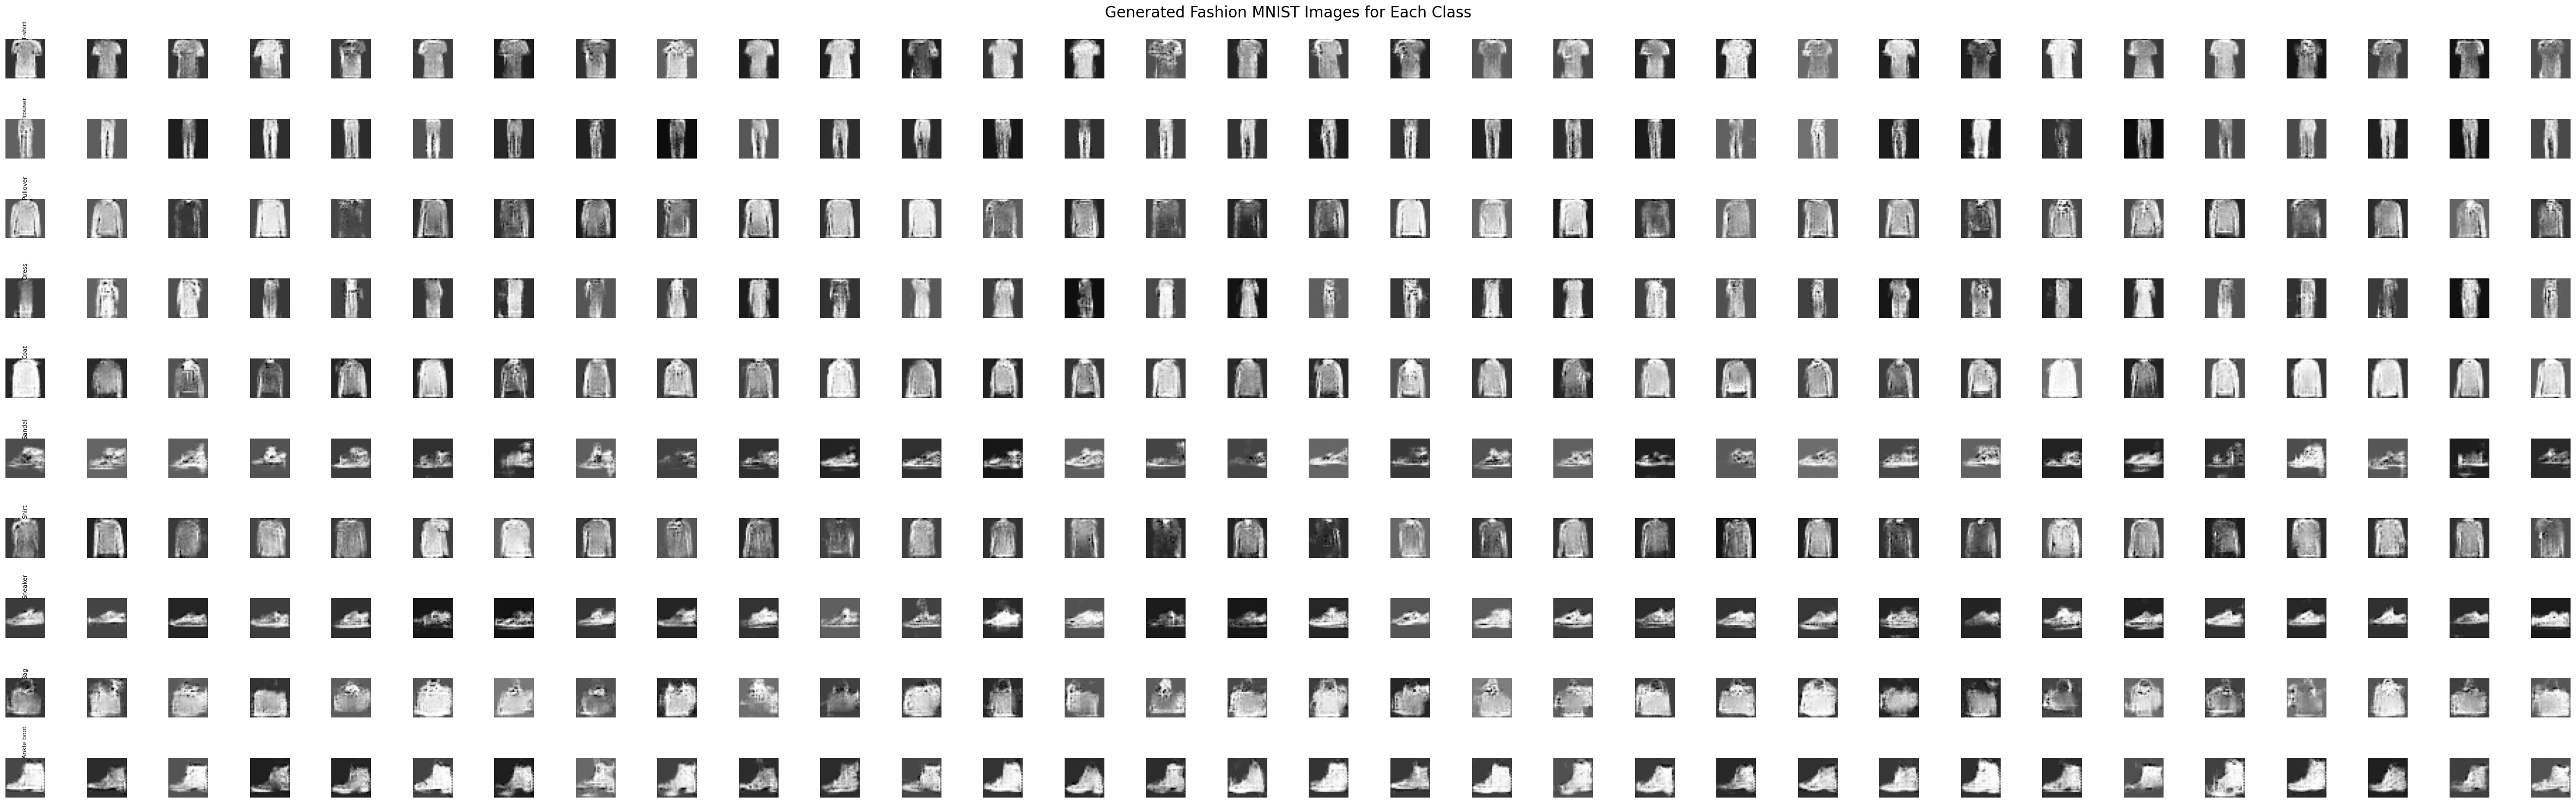

In [51]:
generate_and_plot_fashion_mnist(generator = generator, n_images=32, n_classes=10)

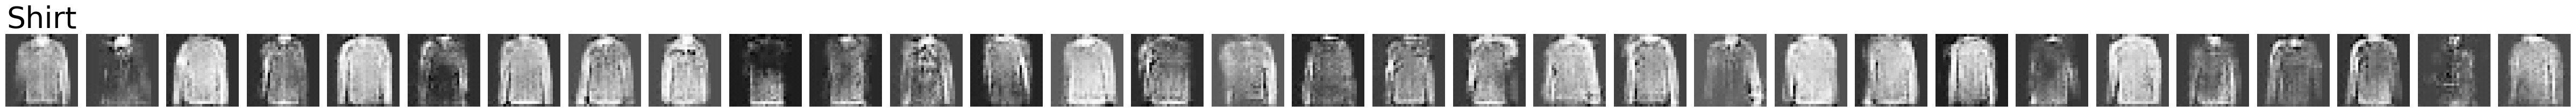

In [52]:
generate_plot_class(generator = generator, n_images=32, class_label=6)